# Titanic dataset

This assigment consists of the introductory problem [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic). The goal is to train a classifier to predict persons that have survived the disaster. 

We will start by reading in the, by now standard, Titanic dataset. It contains information about passengers of the Titanic. The information includes i.a. sex, age, name  and passenger class as well as information if the passenger survived or died in the disaster. You can find more details about this data set [here](http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf). 

The data  is in "coma separated values" (csv) format and to read it we will use the [pandas](https://pandas.pydata.org) library. Pandas  provides tools for manipulating  data frames and series and is wildly used in data science projects. 

Please note that this is NOT a pandas manual. For detailed explanation of the concepts and functions used here you should consult the [documentation](https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
data = pd.read_csv("titanic3.csv")

`data` is a pandas  [_DataFrame_](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object. 

In [3]:
type(data)

pandas.core.frame.DataFrame

We can check what attributes are stored in the DataFrame by listing the column names:

In [3]:
data.columns

Index(['Unnamed: 0', 'pclass', 'survived', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body',
       'home.dest'],
      dtype='object')

or get a quick preview using ```head``` function: 

In [5]:
data.head(2)

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


For the description of those features please see the before mentioned [link](http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf). 

Another usefull function is ```info```:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1309 non-null   int64  
 1   pclass      1309 non-null   int64  
 2   survived    1309 non-null   int64  
 3   name        1309 non-null   object 
 4   sex         1309 non-null   object 
 5   age         1046 non-null   float64
 6   sibsp       1309 non-null   int64  
 7   parch       1309 non-null   int64  
 8   ticket      1309 non-null   object 
 9   fare        1308 non-null   float64
 10  cabin       295 non-null    object 
 11  embarked    1307 non-null   object 
 12  boat        486 non-null    object 
 13  body        121 non-null    float64
 14  home.dest   745 non-null    object 
dtypes: float64(3), int64(5), object(7)
memory usage: 153.5+ KB


As we can see not all attributes are know (non-null) for every passanger. This is a frequent situation in real datasets. 

## Problem 1

#### a) Implement a Bayes classifier for predicting passenger survival  using sex and pclass  features. 

#### Preliminaries

We will start by extracting from the frame  only the information we need:

In [3]:
data_selected = data[['pclass', 'sex', 'survived']]

In [6]:
data_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 3 columns):
pclass      1309 non-null int64
sex         1309 non-null object
survived    1309 non-null int64
dtypes: int64(2), object(1)
memory usage: 30.8+ KB


In [9]:
data_selected.head(5)

,pclass,sex,survived
0,1,female,1
1,1,male,1
2,1,female,0
3,1,male,0
4,1,female,0


First we need to group passengers according to sex, class and survival status. This can be achieved using  the [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function:

In [4]:
grouped = data_selected.groupby(['survived','sex','pclass'])

We can count the number of passegers in each group using function ```size```:

In [5]:
counts = grouped.size()

Object ```counts``` contains all the information that we need to construct the classifier:

In [91]:
counts

survived  sex     pclass
0         female  1           5
                  2          12
                  3         110
          male    1         118
                  2         146
                  3         418
1         female  1         139
                  2          94
                  3         106
          male    1          61
                  2          25
                  3          75
dtype: int64

`counts` is a pandas [_Series_](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) object indexed by a [_MultiIndex_](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#advanced-hierarchical).

In [13]:
counts.index

MultiIndex([(0, 'female', 1),
            (0, 'female', 2),
            (0, 'female', 3),
            (0,   'male', 1),
            (0,   'male', 2),
            (0,   'male', 3),
            (1, 'female', 1),
            (1, 'female', 2),
            (1, 'female', 3),
            (1,   'male', 1),
            (1,   'male', 2),
            (1,   'male', 3)],
           names=['survived', 'sex', 'pclass'])

We can treat a multi-indexed series as an multi-dimensional table with each level of the index corresponding to one dimension. You can index `counts` to obtain information on specified entry: 

In [92]:
counts[1,'female',2]

94

The index is hierarchical, if we do not provide all indices a subset of elements will be returned e.g. 

In [15]:
counts[1,'female']

pclass
1    139
2     94
3    106
dtype: int64

list the number of male surviving women  in each class. Similarly 

In [16]:
counts[1]

sex     pclass
female  1         139
        2          94
        3         106
male    1          61
        2          25
        3          75
dtype: int64

lists the number of survivors for each sex and class.

It is however better to use the `loc` function. With this function we can also use the _slicing_ notation. For example 

In [93]:
counts.loc[0, :,3]

survived  sex     pclass
0         female  3         110
          male    3         418
dtype: int64

list non-survivors in third class  regardless of sex. 

Both `[]` and `loc[]` can  also take a _tuple_ as an argument: 

In [18]:
counts.loc[(0, 'female',3)]

110

but the use of slice notation in touple is not permitted. You can use it by providing an explicit _slice_ object 

In [19]:
counts.loc[(0, slice(None),3)]

survived  sex     pclass
0         female  3         110
          male    3         418
dtype: int64

Function `sum`  as expected returns the sum of all the entries of the series

In [6]:
n_passengers = counts.sum()
n_survivors = counts[1].sum()
n_dead = counts[0].sum()

print(n_passengers, n_survivors, n_dead)
print(n_survivors+n_dead==n_passengers)

1309 500 809
True


### Classifier

To implement classifier we need to calculate the conditional probability of survival given sex and class:

$$P(survived|sex, pclass)$$

We can use the Bayes theorem but it will be actually quicker to calculate it directly from the definition:

$$P(survived|sex, pclass)=\frac{P(survived,sex, pclass)}{P(sex, pclass)}
\approx \frac{\#(survived,sex, pclass)}{\#(sex,pclass)}$$

where by $\#$ I have denoted the number of passengers with given attributes. For example the probability of survival for a women traveling in second class is: 

$$\frac{\text{number of women in second class that survived}}{\text{number of women in second class}}$$

which we can calculate as

In [21]:
counts[(1,'female',2)]/(counts[(1,'female',2)]+counts[(0,'female',2)])

0.8867924528301887

This operation has to be repeated for every sex and class combination. We do not have to do it index by index. Pandas have overloaded arithmetic operations that work  on all indices at once e.g. 

In [7]:
by_sex_class = counts.loc[0]+counts.loc[1]

creates a series with number of passengers of each gender and class

In [8]:
by_sex_class

sex     pclass
female  1         144
        2         106
        3         216
male    1         179
        2         171
        3         493
dtype: int64

Same effect can be achieved by passing `level` argument to the series `sum` function. The level argument lists the levels which are __not__ summed over. To sum over the `survived` level we use

In [8]:
by_sex_class = counts.sum(level=['sex','pclass'])

Using `counts` and `by_sex_class` you can calculate required conditional propabilities. 

In [9]:
p_surv_cond_sex_pclass = (counts/by_sex_class)
p_surv_cond_sex_pclass = p_surv_cond_sex_pclass.reorder_levels(['survived','sex','pclass']).sort_index()

In [20]:
p_surv_cond_sex_pclass

survived  sex     pclass
0         female  1         0.034722
                  2         0.113208
                  3         0.509259
          male    1         0.659218
                  2         0.853801
                  3         0.847870
1         female  1         0.965278
                  2         0.886792
                  3         0.490741
          male    1         0.340782
                  2         0.146199
                  3         0.152130
dtype: float64

In the above expression we have used a very useful feature of pandas series. When performing an arithmetic operation  the elements of the series are _joined_ based on the common index levels.  

Let's  look at it in more detail:

`counts` have three levels of index

In [90]:
counts.index.names

FrozenList(['survived', 'sex', 'pclass'])

and `by_sex_class` has two

In [28]:
by_sex_class.index.names

FrozenList(['sex', 'pclass'])

Levels 'sex' and 'pclass' are common to both indexes so the expression

p_surv_cond_sex_pclass = (counts/by_sex_class)

will have a three level index with  levels 'survived', 'sex' and 'pclass'  and is equivalent to:

In [10]:
p_surv_cond_sex_pclass = pd.Series(0,index=counts.index)
for survived, sex, pclass in counts.index: 
    p = counts.loc[survived, sex, pclass]/by_sex_class.loc[sex, pclass]
    p_surv_cond_sex_pclass.loc[(survived, sex, pclass)] = p

Unfortunatelly this join operation also reorders the levels of the multi index so we have to order them back using `reorder_levels` and `sort_index` function.

```p_surv_cond_sex_pclass = (counts/by_sex_class).reorder_levels(['survived','sex','pclass']).sort_index()```

We can check that we indeed get the identical values

In [12]:
p_surv_cond_sex_pclass.sum(level=['sex', 'pclass'])

sex     pclass
female  1         1.0
        2         1.0
        3         1.0
male    1         1.0
        2         1.0
        3         1.0
dtype: float64

#### b) Calculate TPR and FPR on the whole set. Draw the ROC curve and calculate AUC score

The TPR is the fraction of survivors that were classified as survivors. And FPR is the fraction of dead persons that were classified as survivors. We classify a person as survivor when the probability of survival is  greater or equal to one half. 

For ROC and AUC use the functions from scikit-learn library.

In [43]:
p_surv_cond_sex_pclass[1, 'female', 1]

0.9652777777777778

In [11]:
tp = 0
fp = 0
tpr = []
fpr = []

for index, row in data_selected.iterrows():
    if p_surv_cond_sex_pclass[1, row['sex'], row['pclass']] >= 0.5 and row['survived'] == 1:
        tp += 1
    if p_surv_cond_sex_pclass[1, row['sex'], row['pclass']] >= 0.5 and row['survived'] == 0:
        fp += 1
    tpr.append(tp / n_survivors)
    fpr.append(fp / n_dead)

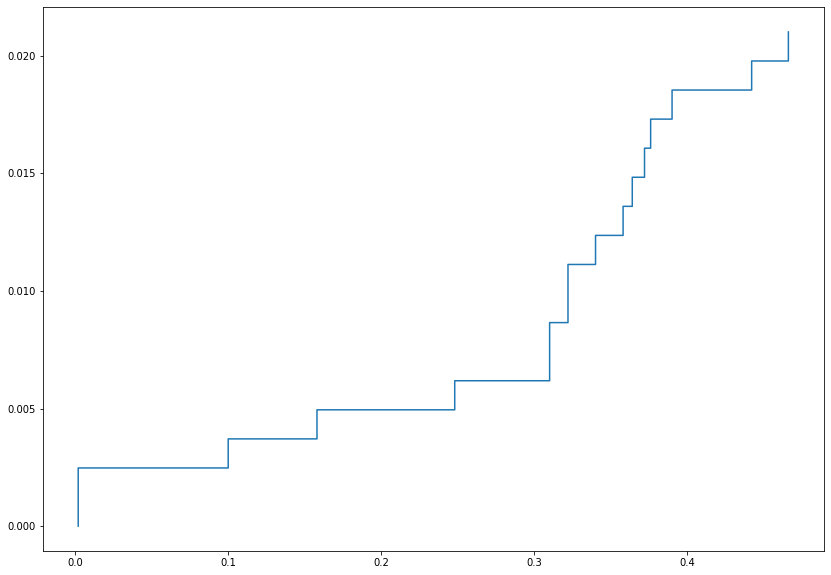

In [12]:
plt.figure(figsize=(14, 10))
plt.plot(tpr, fpr)
plt.show()

#### c) Are those features conditionally independent? 

To answer this question we need to compare conditional probability distribution

$$P(sex,pclass|survived)$$

with

$$P(sex|survived)\times P(pclass|survived)$$ 

By definition

$$P(sex,pclass|survived)= \frac{P(sex,pclass,survived)}{P(survived)}$$

which can be calculated based on the `counts` object. 

In [25]:
data_selected.head()

,pclass,sex,survived
0,1,female,1
1,1,male,1
2,1,female,0
3,1,male,0
4,1,female,0


In [62]:
p_sex_survived = counts.sum(level = ['survived', 'sex'])
n_survived = counts.sum(level = ['survived'])
p_sex_cond_survived = pd.Series(0.0, index = p_sex_survived.index)
p_sex_cond_survived = p_sex_survived / n_survived

p_pclass_survived = counts.sum(level = ['survived', 'pclass'])
p_pclass_cond_survived = pd.Series(0.0, index = p_pclass_survived.index)
p_pclass_cond_survived = p_pclass_survived / n_survived

p_sex_pclass_survived = counts.sum(level = ['survived', 'sex', 'pclass'])
p_sex_pclass_cond_survived = pd.Series(0.0, index = counts.index)
p_sex_pclass_cond_survived = p_sex_pclass_survived / n_survived

print("p_sex_pclass_cond_survived")
print(p_sex_pclass_cond_survived)

print("\np_sex_cond_survived * p_pclass_cond_survived")
print(p_sex_cond_survived * p_pclass_cond_survived)
print("\nFeatures aren't conditionally independent")

p_sex_pclass_cond_survived
survived  sex     pclass
0         female  1         0.006180
                  2         0.014833
                  3         0.135970
          male    1         0.145859
                  2         0.180470
                  3         0.516687
1         female  1         0.278000
                  2         0.188000
                  3         0.212000
          male    1         0.122000
                  2         0.050000
                  3         0.150000
dtype: float64

p_sex_cond_survived * p_pclass_cond_survived
survived  sex     pclass
0         female  1         0.023868
                  2         0.030659
                  3         0.102457
          male    1         0.128172
                  2         0.164643
                  3         0.550201
1         female  1         0.271200
                  2         0.161364
                  3         0.245436
          male    1         0.128800
                  2         0.076636
           

#### d) Implement a Naive bayes classifier using same features and compare it with a). 

We  have already calculated the probability 

$$P_{NB}(sex,pclass|survived) = P(sex|survived)\times P(pclass|survived)$$

From which we can calculate 

$$P_{NB}(survived|sex,pclass)= \frac{P_{NB}(sex,pclass|survivedP(survived)}{P(sex,pclass)}$$

In [43]:
#p_sex_pclass = counts.sum(level = ['sex', 'pclass'])
#p_survived_cond_sex_pclass = (p_sex_pclass_cond_survived * n_survivors) / p_sex_pclass

#p_survived_cond_sex_pclass

sex     pclass  survived
female  1       0           0.021460
                1           0.965278
        2       0           0.069968
                1           0.886792
        3       0           0.314746
                1           0.490741
male    1       0           0.407428
                1           0.340782
        2       0           0.527689
                1           0.146199
        3       0           0.524024
                1           0.152130
dtype: float64

In [77]:
p_survived = counts.sum(level = ['survived']) / n_passengers
#p_nb_sex_pclass = p_sex_pclass_cond_survived * p_survived

p_nb_sex_pclass = p_sex_pclass_cond_survived[1] * p_survived[1] + p_sex_pclass_cond_survived[0] * p_survived[0]
p_survived_cond_sex_pclass = (p_sex_pclass_cond_survived * p_survived) / p_nb_sex_pclass

p_survived_cond_sex_pclass

sex     pclass  survived
female  1       0           0.034722
                1           0.965278
        2       0           0.113208
                1           0.886792
        3       0           0.509259
                1           0.490741
male    1       0           0.659218
                1           0.340782
        2       0           0.853801
                1           0.146199
        3       0           0.847870
                1           0.152130
dtype: float64

## Problem 2

##### Add age as a feature and implement naive bayes classifier. 

#### Hint: 
Consider using it as a categorical variable

We start by constructning a new dataframe with age added:

In [26]:
data_with_age = data_selected.copy()

In [27]:
data_with_age['age'] = data['age']

In [28]:
data_with_age_filled = data_with_age.fillna(data_with_age.age.median())

We will divide age into categories. Just for fun I will define a function that returns a categorizing function

In [29]:
def make_age_categorizer(limits, lbls):
    def categorizer(age):
        for i,l in enumerate(limits):
            if age<=l:
                return lbls[i]
        return lbls[-1]    

    return categorizer
    

Somewhat arbitrarly I will classify all younger then 12 years as children, between 12 and 60 as adults and older as seniors

In [30]:
ctg = make_age_categorizer([12,60],['child','adult','senior'])

We can use the `cgt` function to add new column containing age categories to dataframe

In [31]:
data_with_age_filled['age_category']=data_with_age_filled.age.apply(ctg)

and group it by all categories

In [32]:
counts_with_age_filled = data_with_age_filled.groupby( ['survived', 'sex', 'pclass', 'age_category']).size()

In [33]:
counts_with_age_filled

survived  sex     pclass  age_category
0         female  1       adult             3
                          child             1
                          senior            1
                  2       adult            12
                  3       adult            94
                          child            16
          male    1       adult           104
                          senior           14
                  2       adult           141
                          senior            5
                  3       adult           390
                          child            23
                          senior            5
1         female  1       adult           134
                          senior            5
                  2       adult            81
                          child            13
                  3       adult            91
                          child            14
                          senior            1
          male    1       adult          

From now on we can proceed as before

In [80]:
p_sex_pclass_age_survived = counts_with_age_filled.sum(level = ['survived', 'sex', 'pclass',
                                                         'age_category'])

p_sex_pclass_age_cond_survived = pd.Series(0.0,index = p_sex_pclass_age_survived.index)
p_sex_pclass_age_cond_survived = p_sex_pclass_age_survived / n_survived

p_nb_sex_pclass_age = p_sex_pclass_age_cond_survived[0] * p_survived[0] + p_sex_pclass_age_cond_survived[1] * p_survived[1]
p_survived_cond_sex_pclass_age = (p_sex_pclass_age_cond_survived * p_survived) / p_nb_sex_pclass_age
p_survived_cond_sex_pclass_age = p_survived_cond_sex_pclass_age.reorder_levels(['survived','sex','pclass', 'age_category']).sort_index()

p_survived_cond_sex_pclass_age


survived  sex     pclass  age_category
0         female  1       adult           0.021898
                          child                NaN
                          senior          0.166667
                  2       adult           0.129032
                  3       adult           0.508108
                          child           0.533333
          male    1       adult           0.650000
                          senior          0.933333
                  2       adult           0.915584
                          senior          0.833333
                  3       adult           0.860927
                          child           0.657143
                          senior               NaN
1         female  1       adult           0.978102
                          senior          0.833333
                  2       adult           0.870968
                          child                NaN
                  3       adult           0.491892
                          child           0